# ANUGA - Channel1.py example

Channel with space-varying topography

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri

%matplotlib inline
import anuga

In [2]:
name = "channel3"

## Setup the simulation

Computational domain

In [3]:
length = 40.
width = 5.
dx = dy = 0.5          # Resolution: Length of subdivisions on both axes
domain = anuga.rectangular_cross_domain(int(length/dx), int(width/dy),
                                        len1=length, len2=width)
                                        

domain.set_name(name)                 # Output name

Initial condition

In [4]:
def topography(x,y):
    """Complex topography defined by a function of vectors x and y."""

    z = -x/10

    N = len(x)
    for i in range(N):
        # Step
        if 10 < x[i] < 12:
            z[i] += 0.4 - 0.05*y[i]

        # Constriction
        if 27 < x[i] < 29 and y[i] > 3:
            z[i] += 2

        # Pole
        if (x[i] - 34)**2 + (y[i] - 2)**2 < 0.4**2:
            z[i] += 2

    return z

In [5]:
domain.set_quantity('elevation', topography) # Use function for elevation
domain.set_quantity('friction', 0.01)        # Constant friction 
domain.set_quantity('stage', expression='elevation')  # Dry initial condition

Boundary conditions

In [6]:
Bi = anuga.Dirichlet_boundary([0.4, 0, 0])   # Inflow
Br = anuga.Reflective_boundary(domain)       # Solid reflective wall
Bo = anuga.Dirichlet_boundary([-5, 0, 0])    # Outflow

domain.set_boundary({'left': Bi, 'right': Br, 'top': Br, 'bottom': Br})


## Evolve the simulation

In [7]:
for t in domain.evolve(yieldstep=0.1, finaltime=16.0):
    print domain.timestepping_statistics()

    if domain.get_quantity('stage').\
           get_values(interpolation_points=[[10, 2.5]]) > 0:
        print 'Stage > 0: Changing to outflow boundary'
        domain.set_boundary({'right': Bo})


## Process the results

Read all frames from the .sww file at once

In [8]:
out = anuga.utilities.plot_utils.get_output(name+'.sww') #vertex values
outc =  anuga.utilities.plot_utils.get_centroids(out) #centroid values

Plot the grid

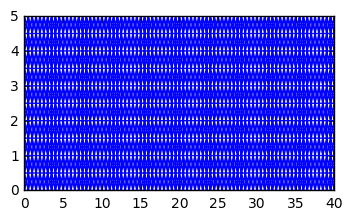

In [9]:
triang = tri.Triangulation(out.x,out.y,out.vols)
plt.figure(figsize=(4,2.25))
plt.triplot(triang)

Pcolor one frame

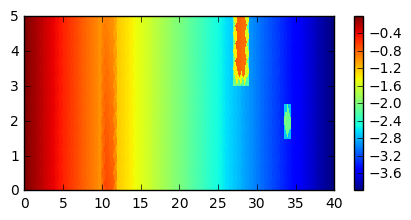

In [10]:
plt.figure(figsize=(4*1.25,2.25))
plt.tripcolor(triang,outc.elev)
plt.colorbar()

Pcolor multiple frames into one animation


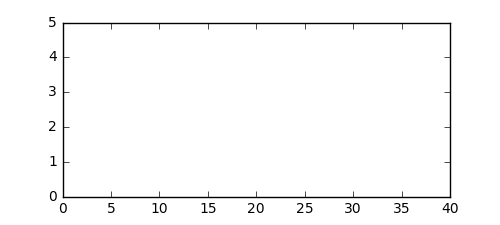
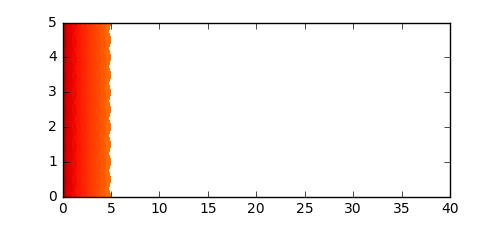
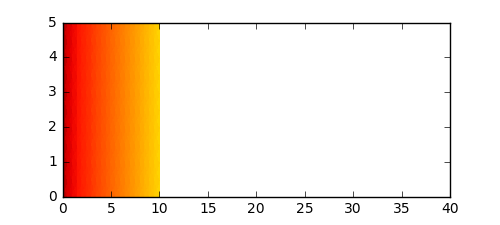
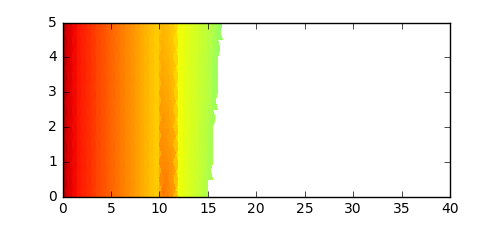
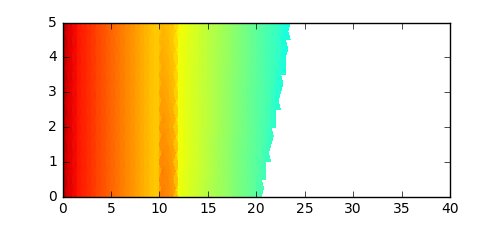
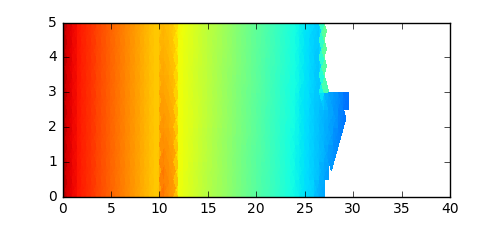
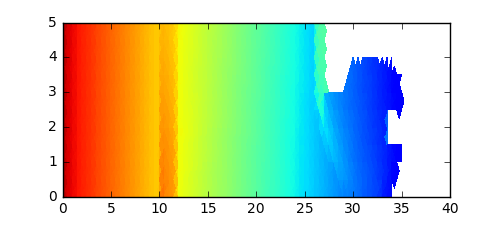
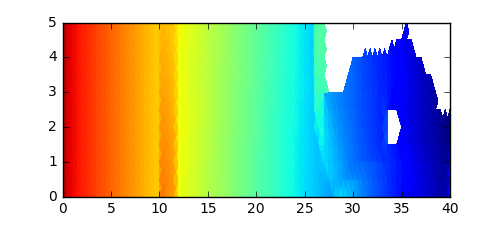
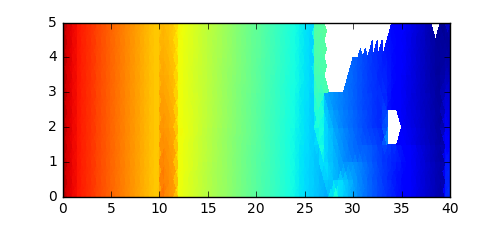
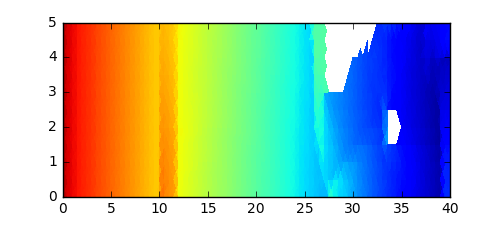

In [11]:
from JSAnimation import IPython_display
from matplotlib import animation

# create a simple animation
fig = plt.figure(figsize=(4*1.25,2.25))
ax = plt.subplot(111)
triang.set_mask(outc.stage[0,:]-outc.elev<=1e-5)
p = ax.tripcolor(triang, outc.stage[0,:],vmin=out.stage.min(),vmax=out.stage.max()*2.0)

def animate(i):
    triang.set_mask(outc.stage[i*int(outc.stage.shape[0]/10.),:]-outc.elev<=1e-5)
    ax.tripcolor(triang,outc.stage[i*int(outc.stage.shape[0]/10.),:],vmin=out.stage.min(),vmax=out.stage.max()*2)
    return p,

animation.FuncAnimation(fig, animate, frames=10, interval=200)

Obtain a profile view of the water at $y=2.0m$

In [12]:
tr = anuga.utilities.plot_utils.near_transect(out,[0,2.5],[40.0,2.0])

Sort values in ascending $x$ order.

In [13]:
tr = list(tr)
sorting = np.argsort(tr[1])
tr[1] = tr[1][sorting]
tr[0] = tr[0][sorting]

Check how the transect looks like

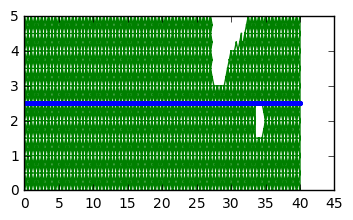

In [14]:
plt.figure(figsize=(4,2.25))
plt.plot(tr[1],np.ones_like(tr[1])*2.5,'.-')
plt.triplot(triang)

Animate these results


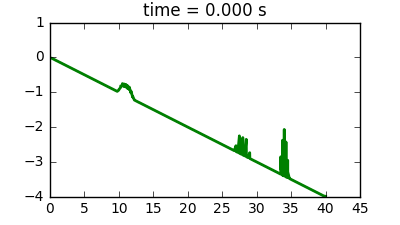
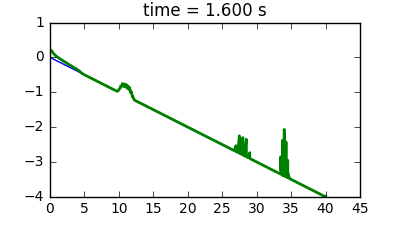
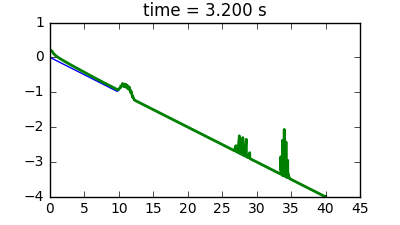
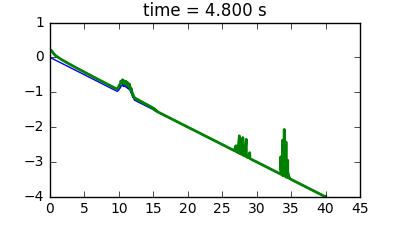
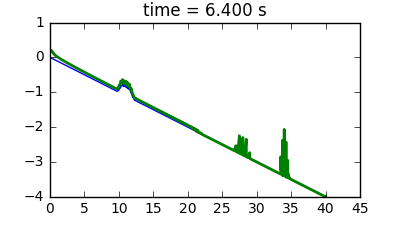
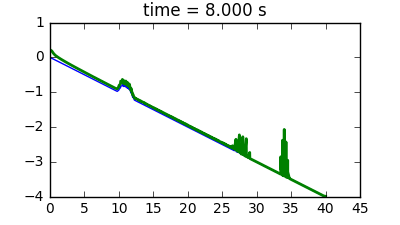
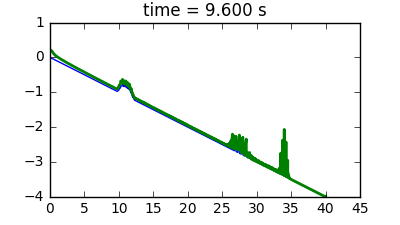
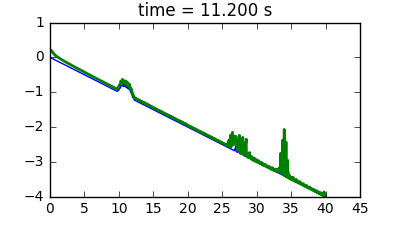
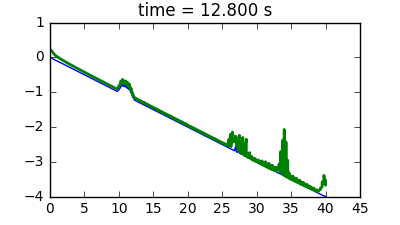
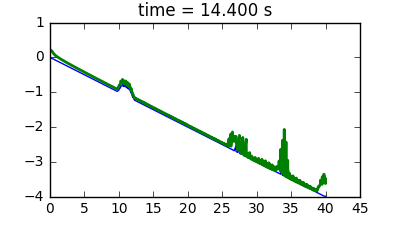

In [15]:
fig = plt.figure(figsize=(4,2.25))
ax = plt.subplot(111)
ax.plot(tr[1], out.elev[tr[0]])
line, = ax.plot([], [], lw=2)
ttl = ax.set_title('time = 0.0 s')
ax.set_ylim(-4,1)
def animate(i):
    line.set_data(tr[1],out.stage[i*int(out.stage.shape[0]/10.),tr[0]])
    ttl.set_text('time = %.3f s'%out.time[i*int(out.stage.shape[0]/10.)])
    
    return line,

animation.FuncAnimation(fig, animate, frames=10, interval=200, blit=True)

## Check min height on results

In [16]:
np.where(out.height>0)

(array([  1,   1,   1, ..., 160, 160, 160]),
 array([   0,    1,    2, ..., 1688, 1689, 1690]))

In [17]:
out.height[np.where(out.height>0)].min()

0.0010001659

In [18]:
out.height[:,tr[0]][np.where(out.height[:,tr[0]]>1e-12)].min()

0.0010046959